# Importing Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf

In [2]:
test = tf.data.Dataset.load('split_tensor/test_ds/')
test_arr = np.array(list(test.as_numpy_iterator()))
masks = test_arr[:,1,:,:,:]
images = test_arr[:,0,:,:,:]

### Creating dictionary from numpy

In [3]:

entropy_models = np.load('Uncertainty_comparison_12-04/entropy_models.npy', allow_pickle=True)
preds_models = np.load('Uncertainty_comparison_12-04/preds_models.npy', allow_pickle=True)

entropy = {}
for i in range(len(entropy_models)):
    model_name = entropy_models[i][0]
    entropy[model_name] = {'entropy_all': entropy_models[i][1],
                        'entropy_gland':entropy_models[i][2],
                        'entropy_cz':entropy_models[i][3],
                        'entropy_pz':entropy_models[i][4],
                        'entropy_tz':entropy_models[i][5],
                        'entropy_tum':entropy_models[i][6]}

preds = {}
for j in range(len(preds_models)):
    model_name = preds_models[j][0]
    preds[model_name] = {'test_argmax_all': preds_models[j][1],
                        'test_argmax_gland':preds_models[j][2],
                        'test_cz':preds_models[j][3],
                        'test_pz':preds_models[j][4],
                        'test_tz':preds_models[j][5],
                        'test_tum':preds_models[j][6]}

list(preds.keys())

['unet',
 'r2unet',
 'attr2unet',
 'swinunet',
 'denseunet',
 'faunet',
 'attunet',
 'attdenseunet']

### Selecting images for plot

In [4]:
lst4 = []
lst3 = []
lst3t = []
lst2 = []
for i in range(len(masks)):
    if (0 in masks[i]) and (1 in masks[i]) and (2 in masks[i]) and (3 in masks[i]) and (4 in masks[i]):
        lst4.append(i)
    elif (0 in masks[i]) and (1 in masks[i]) and (2 in masks[i]) and (3 in masks[i]):
        lst3.append(i)
    elif (0 in masks[i]) and (1 in masks[i]) and (2 in masks[i]) and (4 in masks[i]):
        lst3t.append(i)
    elif (0 in masks[i]) and (1 in masks[i]) and (2 in masks[i]):
        lst2.append(i)

print('Lista 4: ', lst4)
print('Lista 3: ', lst3)
print('Lista 3tumor: ', lst3t)
print('Lista 2: ', lst2)


Lista 4:  [3, 6, 7, 19, 27, 29]
Lista 3:  [1, 2, 5, 11, 13, 15, 18, 20, 22, 26]
Lista 3tumor:  [4, 8, 17, 23]
Lista 2:  [0, 9, 10, 12, 14, 16, 21, 24, 25, 28, 30]


In [5]:
# Selecting images
z2 = 14
z3 = 18
z3t = 17
z4 = 3

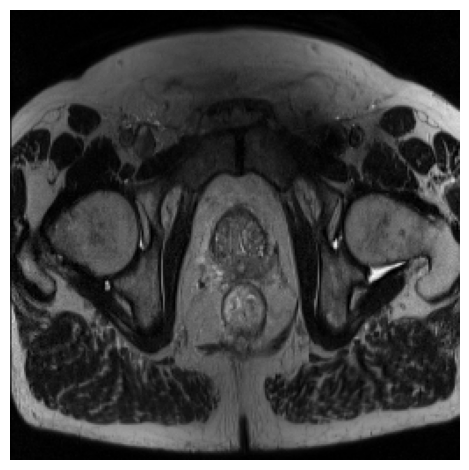

In [6]:
plt.imshow(images[3], cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.savefig('tumor.png', dpi=300)

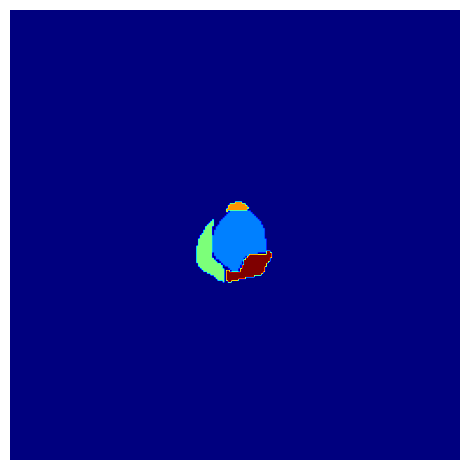

In [7]:
import matplotlib.patches as mpatches
import matplotlib
# color= matplotlib.colors.LinearSegmentedColormap.from_list("", ['black', 'royalblue', 'limegreen', 'orange', 'tomato'])
im = plt.imshow(masks[3], cmap='jet', vmin=0, vmax=4)
plt.axis('off')
plt.tight_layout()
values2 = ['BG','CZ','PZ','TZ','Tumor']
values = [0,1,2,3,4]
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label=values2[i]) for i in range(len(values)) ]

# Plots

## Crop and resize

In [8]:
from functools import reduce
from skimage.transform import resize
start_idx = 256//3
end_idx = 2 * (256//3)

dict_imgs = {}
dict_msks = {}
dict_preds = {}
dict_entropy = {}

names_model = list(preds.keys())
idx = [z2, z3, z3t, z4]
for i in idx:
    cropped_img = images[i][start_idx:end_idx, start_idx:end_idx, :]
    dict_imgs[i] = resize(cropped_img, (256, 256), anti_aliasing=True)
    cropped_msk = masks[i][start_idx:end_idx, start_idx:end_idx, :]
    dict_msks[i] = resize(cropped_msk, (256, 256), anti_aliasing=True)
    entropy_list = []
    preds_list = []
    for j in names_model:
        cropped_ent= entropy[j]['entropy_all'][i][start_idx:end_idx, start_idx:end_idx]
        cropped_ent = resize(cropped_ent, (256, 256), anti_aliasing=False)
        cropped_pred= preds[j]['test_argmax_all'][i][start_idx:end_idx, start_idx:end_idx]
        # cropped_pred = np.repeat(np.repeat(cropped_pred, 2, axis=0), 2, axis=1)
        entropy_list.append({j:cropped_ent})
        preds_list.append({j:cropped_pred})
    dict_entropy[i] = reduce(lambda a, b: {**a, **b}, entropy_list)
    dict_preds[i] = reduce(lambda a, b: {**a, **b}, preds_list)


In [9]:
names_model

['unet',
 'r2unet',
 'attr2unet',
 'swinunet',
 'denseunet',
 'faunet',
 'attunet',
 'attdenseunet']

## Uncertainty subplot

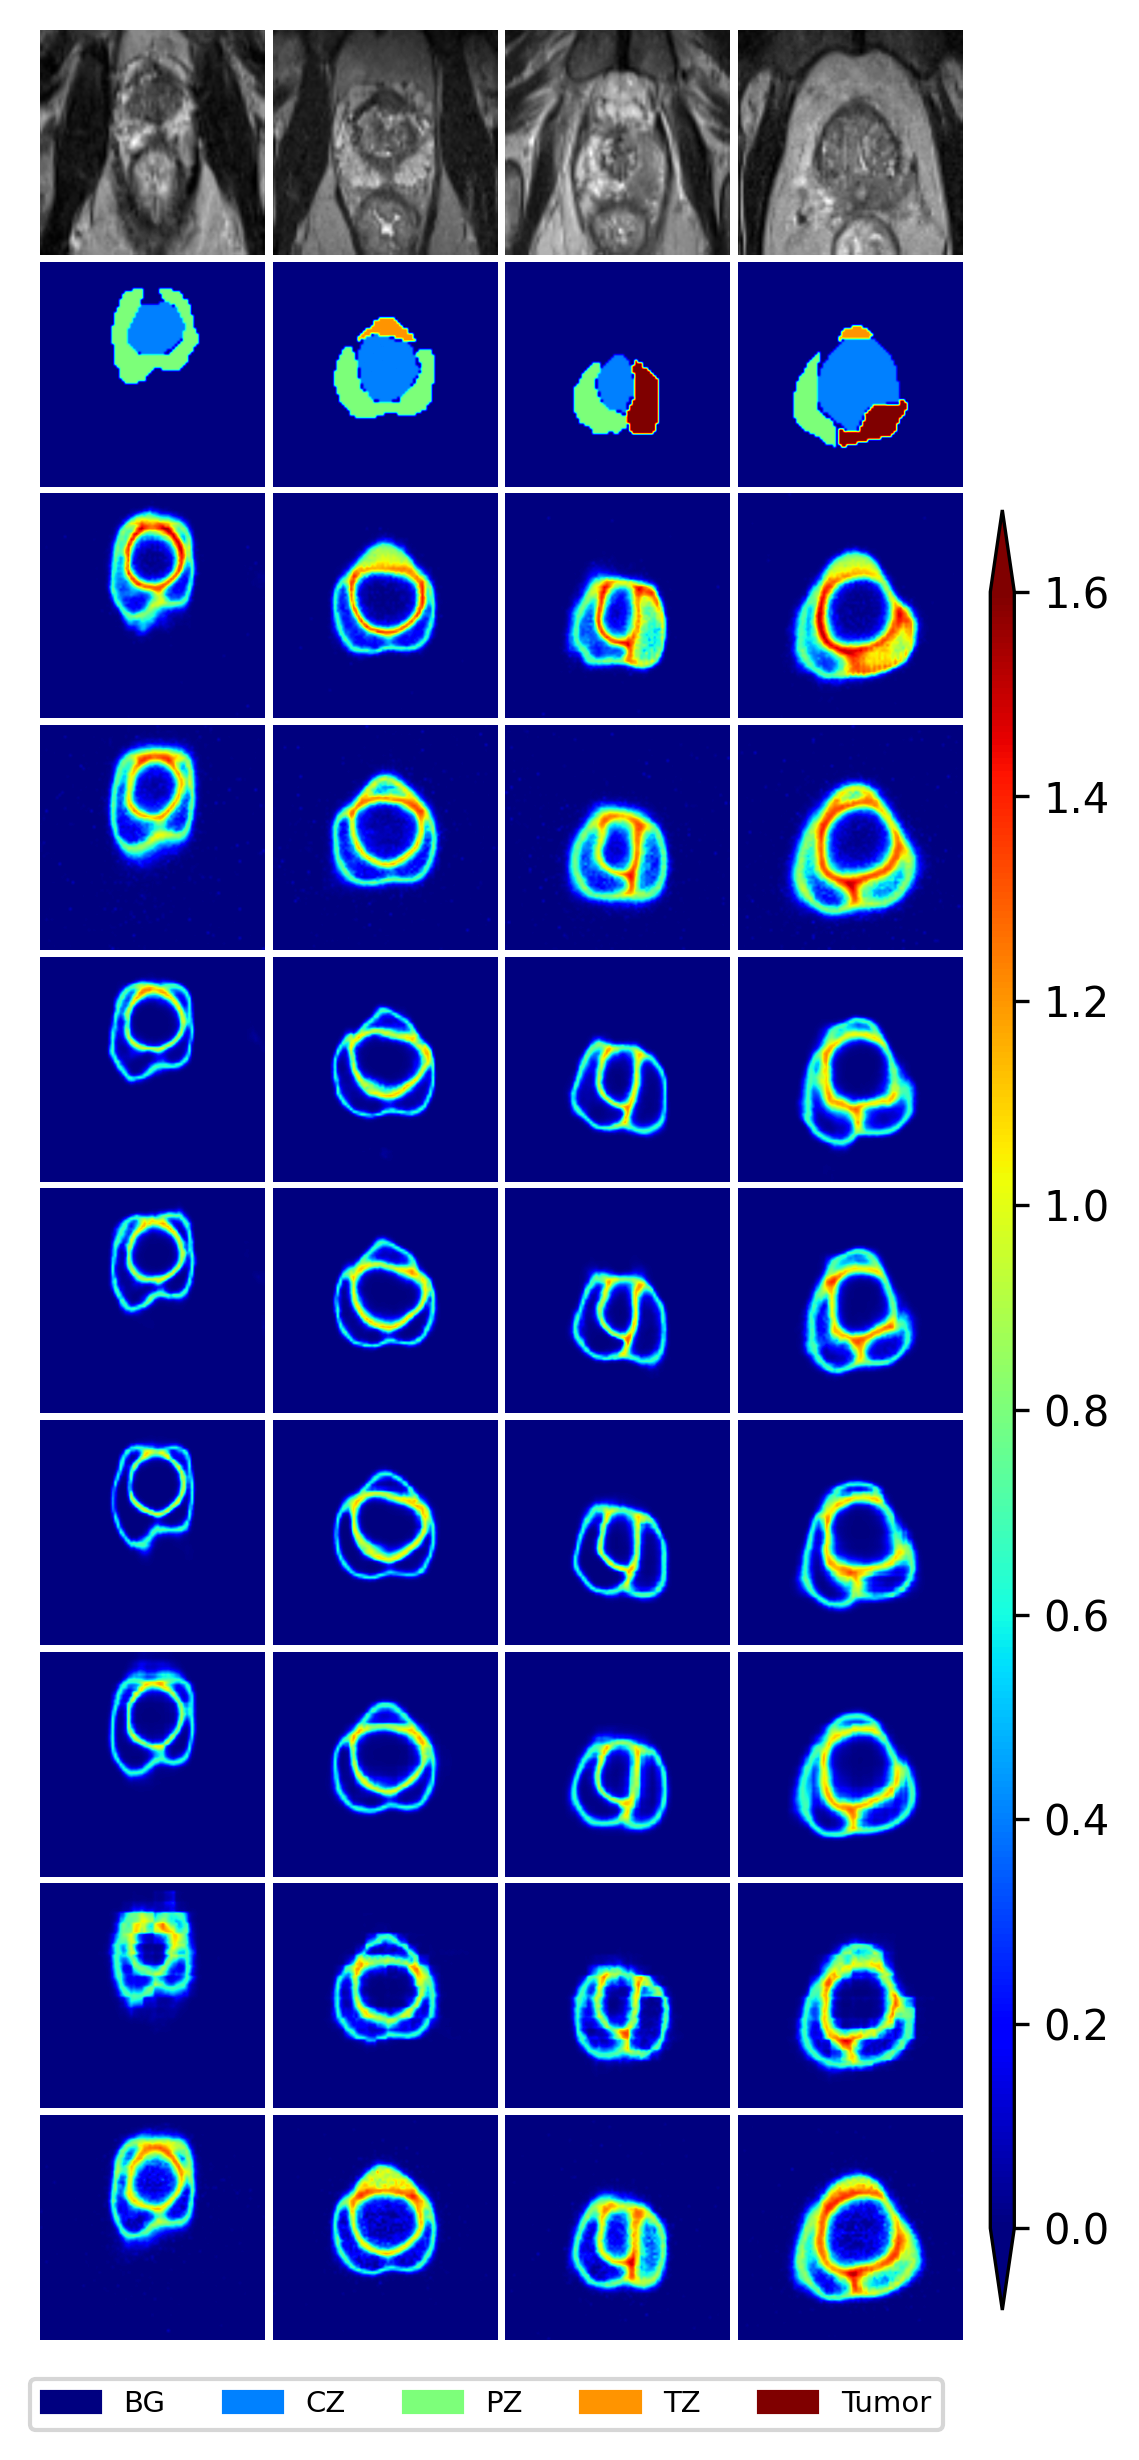

In [10]:
bounds = [0, 1, 2, 3, 4]
colors = ['darkblue', 'deepskyblue', 'brown', 'gold', 'orange']
cmap = mpl.colors.ListedColormap(colors)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


fig, ax = plt.subplots(nrows=10, ncols=4, figsize=(4,10), dpi=300)
ax[0,0].imshow(dict_imgs[z2], cmap='gray')
ax[0,0].axis('off')
ax[1,0].imshow(dict_msks[z2], cmap='jet', vmin=0, vmax=4)
ax[1,0].axis('off')


ax[0,1].imshow(dict_imgs[z3], cmap='gray')
ax[0,1].axis('off')
ax[1,1].imshow(dict_msks[z3], cmap='jet', vmin=0, vmax=4)
ax[1,1].axis('off')


ax[0,2].imshow(dict_imgs[z3t], cmap='gray')
ax[0,2].axis('off')
ax[1,2].imshow(dict_msks[z3t], cmap='jet', vmin=0, vmax=4)
ax[1,2].axis('off')


ax[0,3].imshow(dict_imgs[z4], cmap='gray')
ax[0,3].axis('off')
im1 = ax[1,3].imshow(dict_msks[z4], cmap='jet', vmin=0, vmax=4)
ax[1,3].axis('off')

###############################################


# UNET
ax[2,0].imshow(dict_entropy[z2]['unet'], vmin=0, vmax=1.6, cmap='jet')
ax[2,0].axis('off')
ax[2,1].imshow(dict_entropy[z3]['unet'], vmin=0, vmax=1.6, cmap='jet')
ax[2,1].axis('off')
ax[2,2].imshow(dict_entropy[z3t]['unet'], vmin=0, vmax=1.6, cmap='jet')
ax[2,2].axis('off')
ax[2,3].imshow(dict_entropy[z4]['unet'], vmin=0, vmax=1.6, cmap='jet')
ax[2,3].axis('off')

# Att UNet
ax[3,0].imshow(dict_entropy[z2]['attunet'], vmin=0, vmax=1.6, cmap='jet')
ax[3,0].axis('off')
ax[3,1].imshow(dict_entropy[z3]['attunet'], vmin=0, vmax=1.6, cmap='jet')
ax[3,1].axis('off')
ax[3,2].imshow(dict_entropy[z3t]['attunet'], vmin=0, vmax=1.6, cmap='jet')
ax[3,2].axis('off')
ax[3,3].imshow(dict_entropy[z4]['attunet'], vmin=0, vmax=1.6, cmap='jet')
ax[3,3].axis('off')

# Dense UNet
ax[4,0].imshow(dict_entropy[z2]['denseunet'], vmin=0, vmax=1.6, cmap='jet')
ax[4,0].axis('off')
ax[4,1].imshow(dict_entropy[z3]['denseunet'], vmin=0, vmax=1.6, cmap='jet')
ax[4,1].axis('off')
ax[4,2].imshow(dict_entropy[z3t]['denseunet'], vmin=0, vmax=1.6, cmap='jet')
ax[4,2].axis('off')
ax[4,3].imshow(dict_entropy[z4]['denseunet'], vmin=0, vmax=1.6, cmap='jet')
ax[4,3].axis('off')

# Att denseunet
ax[5,0].imshow(dict_entropy[z2]['attdenseunet'], vmin=0, vmax=1.6, cmap='jet')
ax[5,0].axis('off')
ax[5,1].imshow(dict_entropy[z3]['attdenseunet'], vmin=0, vmax=1.6, cmap='jet')
ax[5,1].axis('off')
ax[5,2].imshow(dict_entropy[z3t]['attdenseunet'], vmin=0, vmax=1.6, cmap='jet')
ax[5,2].axis('off')
im = ax[5,3].imshow(dict_entropy[z4]['attdenseunet'], vmin=0, vmax=1.6, cmap='jet')
ax[5,3].axis('off')

# R2U-Net 
ax[6,0].imshow(dict_entropy[z2]['r2unet'], vmin=0, vmax=1.6, cmap='jet')
ax[6,0].axis('off')
ax[6,1].imshow(dict_entropy[z3]['r2unet'], vmin=0, vmax=1.6, cmap='jet')
ax[6,1].axis('off')
ax[6,2].imshow(dict_entropy[z3t]['r2unet'], vmin=0, vmax=1.6, cmap='jet')
ax[6,2].axis('off')
im = ax[6,3].imshow(dict_entropy[z4]['r2unet'], vmin=0, vmax=1.6, cmap='jet')
ax[6,3].axis('off')

# Att R2U-Net 
ax[7,0].imshow(dict_entropy[z2]['attr2unet'], vmin=0, vmax=1.6, cmap='jet')
ax[7,0].axis('off')
ax[7,1].imshow(dict_entropy[z3]['attr2unet'], vmin=0, vmax=1.6, cmap='jet')
ax[7,1].axis('off')
ax[7,2].imshow(dict_entropy[z3t]['attr2unet'], vmin=0, vmax=1.6, cmap='jet')
ax[7,2].axis('off')
im = ax[7,3].imshow(dict_entropy[z4]['attr2unet'], vmin=0, vmax=1.6, cmap='jet')
ax[7,3].axis('off')

# Swinunet
ax[8,0].imshow(dict_entropy[z2]['swinunet'], vmin=0, vmax=1.6, cmap='jet')
ax[8,0].axis('off')
ax[8,1].imshow(dict_entropy[z3]['swinunet'], vmin=0, vmax=1.6, cmap='jet')
ax[8,1].axis('off')
ax[8,2].imshow(dict_entropy[z3t]['swinunet'], vmin=0, vmax=1.6, cmap='jet')
ax[8,2].axis('off')
im = ax[8,3].imshow(dict_entropy[z4]['swinunet'], vmin=0, vmax=1.6, cmap='jet')
ax[8,3].axis('off')

# FAUNET
ax[9,0].imshow(dict_entropy[z2]['faunet'], vmin=0, vmax=1.6, cmap='jet')
ax[9,0].axis('off')
ax[9,1].imshow(dict_entropy[z3]['faunet'], vmin=0, vmax=1.6, cmap='jet')
ax[9,1].axis('off')
ax[9,2].imshow(dict_entropy[z3t]['faunet'], vmin=0, vmax=1.6, cmap='jet')
ax[9,2].axis('off')
im = ax[9,3].imshow(dict_entropy[z4]['faunet'], vmin=0, vmax=1.6, cmap='jet')
ax[9,3].axis('off')


cbar_ax = fig.add_axes([0.92, 0.12, 0.02, 0.60])

fig.colorbar(im, cax=cbar_ax, extend='both')
plt.subplots_adjust(wspace=0, hspace=0.03)

import matplotlib.patches as mpatches
values2 = ['BG','CZ','PZ','TZ','Tumor']
values = [0,1,2,3,4]
colors = [im1.cmap(im1.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label=values2[i]) for i in range(len(values)) ]

clegend_ax = fig.add_axes([0.93, 0.67, 0.05, 0.07])
leg = fig.legend(handles=patches, ncol=5, prop={'size': 7}, loc=8, borderaxespad=0., bbox_to_anchor=(0.5, 0.08) )

clegend_ax.axis('off')

plt.savefig('uq.png', bbox_inches='tight')

## Prediction subplot

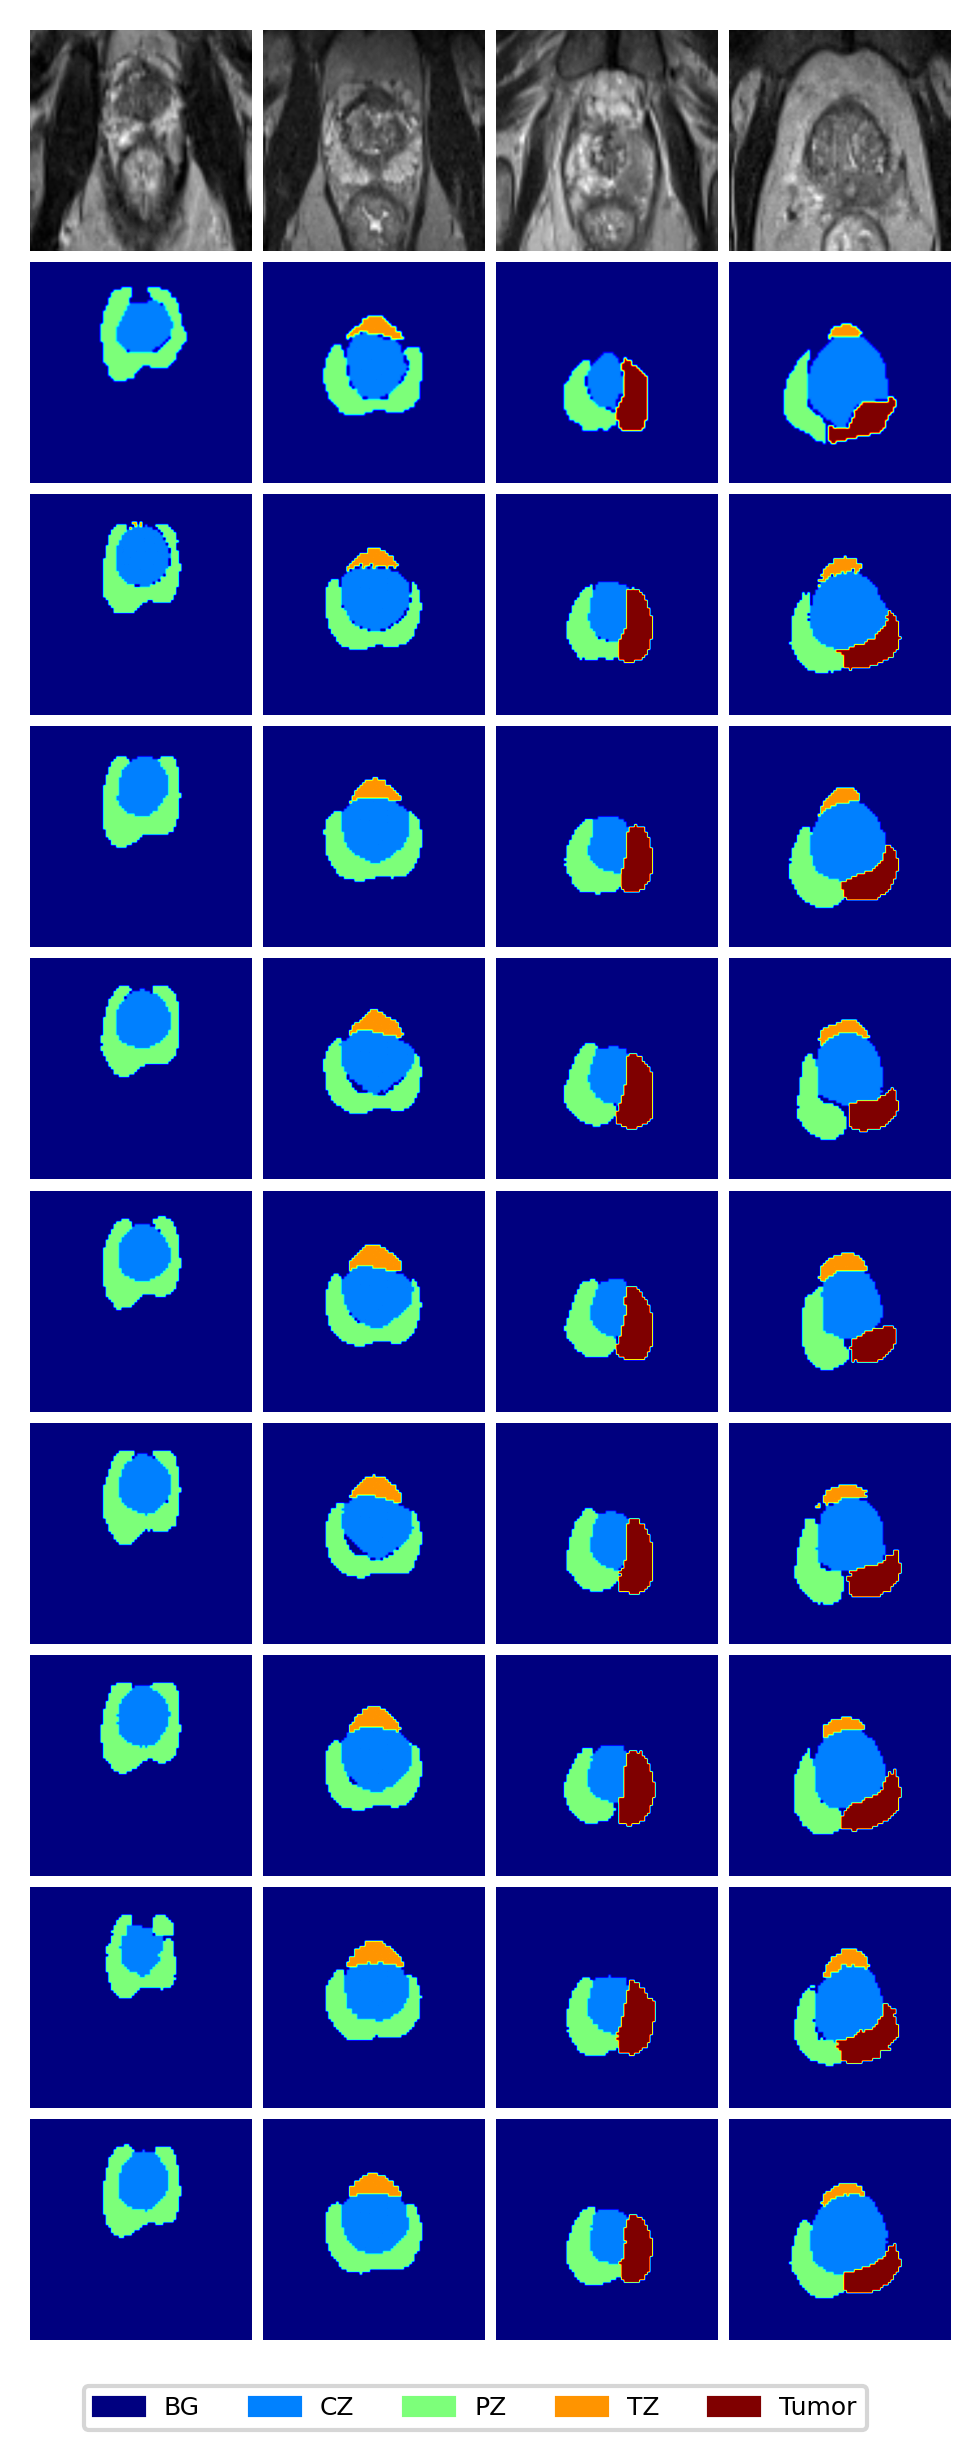

In [11]:

bounds = [0, 1, 2, 3, 4]
colors = ['darkblue', 'deepskyblue', 'brown', 'gold', 'orange']
cmap = mpl.colors.ListedColormap(colors)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


fig, ax = plt.subplots(nrows=10, ncols=4, figsize=(4,10), dpi=300)
ax[0,0].imshow(dict_imgs[z2], cmap='gray')
ax[0,0].axis('off')
ax[1,0].imshow(dict_msks[z2], cmap='jet', vmin=0, vmax=4)
ax[1,0].axis('off')


ax[0,1].imshow(dict_imgs[z3], cmap='gray')
ax[0,1].axis('off')
ax[1,1].imshow(dict_msks[z3], cmap='jet', vmin=0, vmax=4)
ax[1,1].axis('off')


ax[0,2].imshow(dict_imgs[z3t], cmap='gray')
ax[0,2].axis('off')
ax[1,2].imshow(dict_msks[z3t], cmap='jet', vmin=0, vmax=4)
ax[1,2].axis('off')


ax[0,3].imshow(dict_imgs[z4], cmap='gray')
ax[0,3].axis('off')
im1 = ax[1,3].imshow(dict_msks[z4], cmap='jet', vmin=0, vmax=4)
ax[1,3].axis('off')

###############################################


# UNET
ax[2,0].imshow(dict_preds[z2]['unet'], cmap='jet', vmin=0, vmax=4)
ax[2,0].axis('off')
ax[2,1].imshow(dict_preds[z3]['unet'], cmap='jet', vmin=0, vmax=4)
ax[2,1].axis('off')
ax[2,2].imshow(dict_preds[z3t]['unet'], cmap='jet', vmin=0, vmax=4)
ax[2,2].axis('off')
ax[2,3].imshow(dict_preds[z4]['unet'], cmap='jet', vmin=0, vmax=4)
ax[2,3].axis('off')

# Att UNet
ax[3,0].imshow(dict_preds[z2]['attunet'], cmap='jet', vmin=0, vmax=4)
ax[3,0].axis('off')
ax[3,1].imshow(dict_preds[z3]['attunet'], cmap='jet', vmin=0, vmax=4)
ax[3,1].axis('off')
ax[3,2].imshow(dict_preds[z3t]['attunet'], cmap='jet', vmin=0, vmax=4)
ax[3,2].axis('off')
ax[3,3].imshow(dict_preds[z4]['attunet'], cmap='jet', vmin=0, vmax=4)
ax[3,3].axis('off')

# Dense UNet
ax[4,0].imshow(dict_preds[z2]['denseunet'], cmap='jet', vmin=0, vmax=4)
ax[4,0].axis('off')
ax[4,1].imshow(dict_preds[z3]['denseunet'], cmap='jet', vmin=0, vmax=4)
ax[4,1].axis('off')
ax[4,2].imshow(dict_preds[z3t]['denseunet'], cmap='jet', vmin=0, vmax=4)
ax[4,2].axis('off')
ax[4,3].imshow(dict_preds[z4]['denseunet'], cmap='jet', vmin=0, vmax=4)
ax[4,3].axis('off')

# Att denseunet
ax[5,0].imshow(dict_preds[z2]['attdenseunet'], cmap='jet', vmin=0, vmax=4)
ax[5,0].axis('off')
ax[5,1].imshow(dict_preds[z3]['attdenseunet'], cmap='jet', vmin=0, vmax=4)
ax[5,1].axis('off')
ax[5,2].imshow(dict_preds[z3t]['attdenseunet'], cmap='jet', vmin=0, vmax=4)
ax[5,2].axis('off')
im = ax[5,3].imshow(dict_preds[z4]['attdenseunet'], cmap='jet', vmin=0, vmax=4)
ax[5,3].axis('off')

# R2U-Net 
ax[6,0].imshow(dict_preds[z2]['r2unet'], cmap='jet', vmin=0, vmax=4)
ax[6,0].axis('off')
ax[6,1].imshow(dict_preds[z3]['r2unet'], cmap='jet', vmin=0, vmax=4)
ax[6,1].axis('off')
ax[6,2].imshow(dict_preds[z3t]['r2unet'], cmap='jet', vmin=0, vmax=4)
ax[6,2].axis('off')
im = ax[6,3].imshow(dict_preds[z4]['r2unet'], cmap='jet', vmin=0, vmax=4)
ax[6,3].axis('off')

# Att R2U-Net 
ax[7,0].imshow(dict_preds[z2]['attr2unet'], cmap='jet', vmin=0, vmax=4)
ax[7,0].axis('off')
ax[7,1].imshow(dict_preds[z3]['attr2unet'], cmap='jet', vmin=0, vmax=4)
ax[7,1].axis('off')
ax[7,2].imshow(dict_preds[z3t]['attr2unet'], cmap='jet', vmin=0, vmax=4)
ax[7,2].axis('off')
im = ax[7,3].imshow(dict_preds[z4]['attr2unet'], cmap='jet', vmin=0, vmax=4)
ax[7,3].axis('off')

# Swinunet
ax[8,0].imshow(dict_preds[z2]['swinunet'], cmap='jet', vmin=0, vmax=4)
ax[8,0].axis('off')
ax[8,1].imshow(dict_preds[z3]['swinunet'], cmap='jet', vmin=0, vmax=4)
ax[8,1].axis('off')
ax[8,2].imshow(dict_preds[z3t]['swinunet'], cmap='jet', vmin=0, vmax=4)
ax[8,2].axis('off')
im = ax[8,3].imshow(dict_preds[z4]['swinunet'], cmap='jet', vmin=0, vmax=4)
ax[8,3].axis('off')

# FAUNET
ax[9,0].imshow(dict_preds[z2]['faunet'], cmap='jet', vmin=0, vmax=4)
ax[9,0].axis('off')
ax[9,1].imshow(dict_preds[z3]['faunet'], cmap='jet', vmin=0, vmax=4)
ax[9,1].axis('off')
ax[9,2].imshow(dict_preds[z3t]['faunet'], cmap='jet', vmin=0, vmax=4)
ax[9,2].axis('off')
im = ax[9,3].imshow(dict_preds[z4]['faunet'], cmap='jet', vmin=0, vmax=4)
ax[9,3].axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.05)
# plt.tight_layout()

import matplotlib.patches as mpatches
values2 = ['BG','CZ','PZ','TZ','Tumor']
values = [0,1,2,3,4]
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label=values2[i]) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
fig.legend(handles=patches, ncol=5, prop={'size': 6}, loc=8, bbox_to_anchor=(0.5, 0.08), borderaxespad=0. )
plt.savefig('preds.png', dpi=300, bbox_inches='tight')



# Boxplot

CZ

In [22]:
predicted_image = entropy['r2unet']['entropy_cz']
bin_cz = []
for i in range(31):
    plt.figure(figsize=(18,6), dpi=300)
    values, bins, bars = plt.hist(predicted_image[i].flatten(),linewidth=0.1, bins=100)
    labels = plt.bar_label(bars, fontsize=12, color='navy')
    plt.close()
    bin_cz.append(bins[1])
# print(values)
bin_cz = np.mean(bin_cz)
bin_cz

0.003678650406392694

In [23]:
bins

array([0.        , 0.00367874, 0.00735748, 0.01103621, 0.01471495,
       0.01839369, 0.02207243, 0.02575116, 0.0294299 , 0.03310864,
       0.03678738, 0.04046612, 0.04414485, 0.04782359, 0.05150233,
       0.05518107, 0.0588598 , 0.06253854, 0.06621728, 0.06989602,
       0.07357476, 0.07725349, 0.08093223, 0.08461097, 0.08828971,
       0.09196844, 0.09564718, 0.09932592, 0.10300466, 0.1066834 ,
       0.11036213, 0.11404087, 0.11771961, 0.12139835, 0.12507708,
       0.12875582, 0.13243456, 0.1361133 , 0.13979203, 0.14347077,
       0.14714951, 0.15082825, 0.15450699, 0.15818572, 0.16186446,
       0.1655432 , 0.16922194, 0.17290067, 0.17657941, 0.18025815,
       0.18393689, 0.18761563, 0.19129436, 0.1949731 , 0.19865184,
       0.20233058, 0.20600931, 0.20968805, 0.21336679, 0.21704553,
       0.22072427, 0.224403  , 0.22808174, 0.23176048, 0.23543922,
       0.23911795, 0.24279669, 0.24647543, 0.25015417, 0.25383291,
       0.25751164, 0.26119038, 0.26486912, 0.26854786, 0.27222

PZ

In [17]:
predicted_image = entropy['r2unet']['entropy_pz']
bin_pz = []
for i in range(31):
    plt.figure(figsize=(18,6), dpi=300)
    values, bins, bars = plt.hist(predicted_image[i].flatten(),linewidth=0.1, bins=100)
    labels = plt.bar_label(bars, fontsize=12, color='navy')
    plt.close()
    bin_pz.append(bins[1])
bin_pz = np.mean(bin_pz)
bin_pz

0.003678705681273931

TZ

In [18]:
predicted_image = entropy['r2unet']['entropy_tz']
bin_tz = []
lsttz = lst3+lst4
for i in lsttz:
    plt.figure(figsize=(18,6), dpi=300)
    values, bins, bars = plt.hist(predicted_image[i].flatten(),linewidth=0.1, bins=100)
    labels = plt.bar_label(bars, fontsize=12, color='navy')
    plt.close()
    bin_tz.append(bins[1])
bin_tz = np.mean(bin_tz)
bin_tz

0.003379790041960067

TUM

In [19]:
predicted_image = entropy['r2unet']['entropy_tum']
bin_tum = []
lsttum = lst3t+lst4
for i in lsttum:
    plt.figure(figsize=(18,6), dpi=300)
    values, bins, bars = plt.hist(predicted_image[i].flatten(),linewidth=0.1, bins=100)
    labels = plt.bar_label(bars, fontsize=12, color='navy')
    plt.close()
    bin_tum.append(bins[1])
bin_tum = np.mean(bin_tum)
bin_tum

0.0036786852565154683

Mean threshold

In [21]:
avg_bin = np.mean([bin_cz, bin_pz, bin_tz, bin_tum])
avg_bin

0.0036039699158698928

In [12]:
import math
def weighted_avg_and_std_arr(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights, axis=(1,2))
    # Fast and numerically precise:
    # variance = np.average((values-average)**2, weights=weights)
    return average


In [38]:
import pandas as pd
dict_boxplot = {}
for name in list(entropy.keys()):
    # thres = 0.0005
    thres = 0.000

    arr = []
    arr2 = []
    idx_tz = []
    idx_tum = []
    for i in range(len(entropy[name]['entropy_tz'])):
        if np.max(entropy[name]['entropy_tz'][i]) >= thres:
            arr.append(entropy[name]['entropy_tz'][i])
        else:
            idx_tz.append(i)
            
        if np.max(entropy[name]['entropy_tum'][i]) >= thres:
            arr2.append(entropy[name]['entropy_tum'][i])
        else:
            idx_tum.append(i)

    idx_tz = np.array(idx_tz)        
    idx_tum = np.array(idx_tum)  


    ent_tz_temp = np.array(arr)
    ent_tum_temp = np.array(arr2)
    # Mean Entropy per image and zone
    ent_cz = weighted_avg_and_std_arr(entropy[name]['entropy_cz'], entropy[name]['entropy_cz']>=thres)
    ent_pz = weighted_avg_and_std_arr(entropy[name]['entropy_pz'], entropy[name]['entropy_pz']>=thres)
    ent_tz = weighted_avg_and_std_arr(ent_tz_temp, ent_tz_temp>thres)
    ent_tum = weighted_avg_and_std_arr(ent_tum_temp, ent_tum_temp>thres)
    ent_gland = weighted_avg_and_std_arr(entropy[name]['entropy_gland'], entropy[name]['entropy_gland']>=thres)
    ent_all = weighted_avg_and_std_arr(entropy[name]['entropy_all'], entropy[name]['entropy_all']>=thres)

    ent_tz2 = []
    ent_tum2 = []
    x=0
    y=0
    for i in range(31):
        if i in idx_tz:
            ent_tz2.append(np.NaN)
        else:
            ent_tz2.append(ent_tz[x])
            x+=1
        if i in idx_tum:
            ent_tum2.append(np.NaN)
        else:
            ent_tum2.append(ent_tum[y])
            y+=1
    ent_tz = np.array(ent_tz2)
    ent_tum = np.array(ent_tum2)

    d = ({"all": ent_all, "gland": ent_gland, "cz": ent_cz, "pz": ent_pz, "tz": ent_tz, "tum": ent_tum})
    dict_boxplot[name] = pd.DataFrame(d, index=range(31))
    # dict_boxplot[name].to_csv(name)


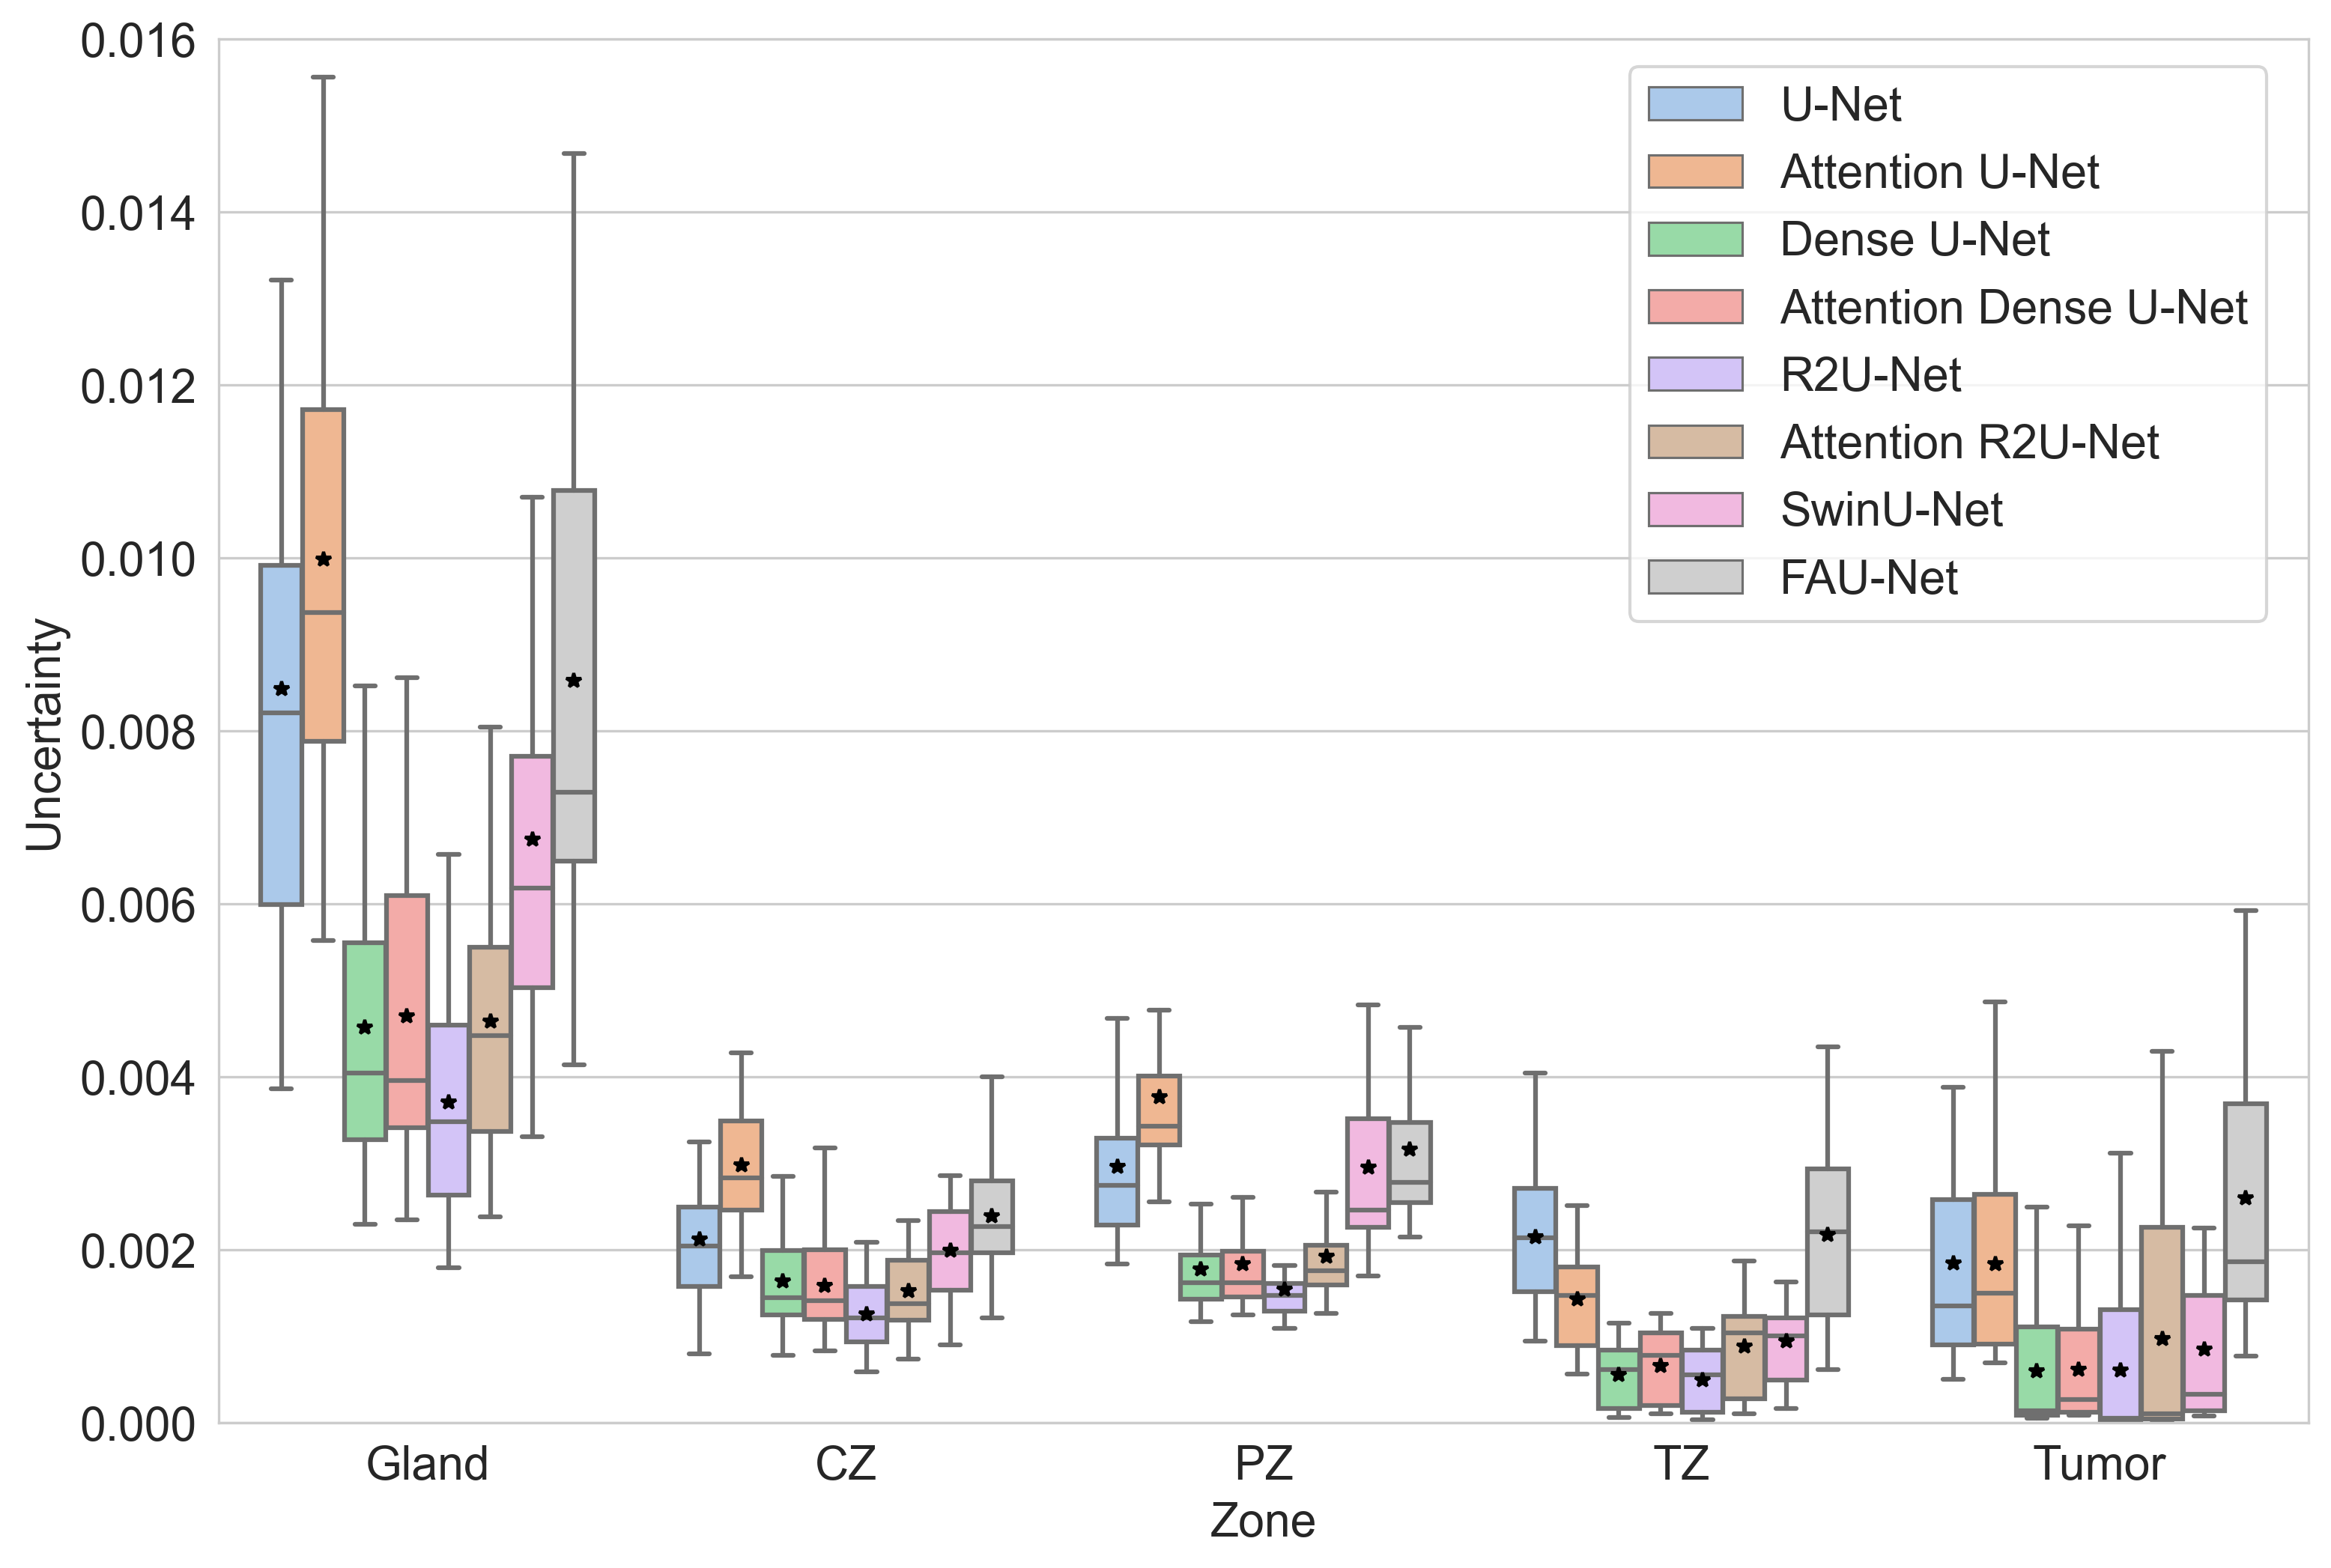

In [56]:
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(1)
import pandas as pd
import seaborn as sns


df_unet = dict_boxplot['unet']
df_unet['model'] = 'U-Net'

df_attunet = dict_boxplot['attunet']
df_attunet['model'] = 'Attention U-Net'

df_denseunet = dict_boxplot['denseunet']
df_denseunet['model'] = 'Dense U-Net'

df_attdenseunet = dict_boxplot['attdenseunet']
df_attdenseunet['model'] = 'Attention Dense U-Net'

df_r2unet = dict_boxplot['r2unet']
df_r2unet['model'] = 'R2U-Net'

df_attr2unet = dict_boxplot['attr2unet']
df_attr2unet['model'] = 'Attention R2U-Net'

df_swinunet = dict_boxplot['swinunet']
df_swinunet['model'] = 'SwinU-Net'

df_faunet = dict_boxplot['faunet']
df_faunet['model'] = 'FAU-Net'


cdf = pd.concat([df_unet, df_attunet, df_denseunet, df_attdenseunet, df_r2unet, df_attr2unet, df_swinunet, df_faunet])
cdf = cdf.rename(columns={'all': 'All', 'gland': 'Gland', 'cz': 'CZ', 'pz': 'PZ', 'tz': 'TZ', 'tum': 'Tumor'})
cdf_without_all = cdf.drop('All', axis=1)
cdf_only_all = cdf[['All', 'model']]

mdf_without_all = pd.melt(cdf_without_all, id_vars=['model'], var_name=['Zone'])
mdf_without_all = mdf_without_all.rename(columns={'value': 'Uncertainty', 'model': 'Model'})

mdf_only_all = pd.melt(cdf_only_all, id_vars=['model'], var_name=['Zone'])
mdf_only_all = mdf_only_all.rename(columns={'value': 'Uncertainty', 'model': 'Model'})

plt.rcParams['font.size'] = 15
plt.figure(figsize=[12,8],dpi=300)
sns.set_style("whitegrid")

# ax_1 = sns.stripplot(x='Zone', y='Uncertainty', hue='Model', data=mdf, size=3, jitter=0.15, dodge= True, 
#               linewidth=0.5,edgecolor='gray', palette='pastel')
ax_2 = sns.boxplot(x="Zone", y="Uncertainty", hue="Model", data=mdf_without_all, fliersize= 0,
                 palette='pastel', showmeans=True, meanprops={"marker": "*",
                       "markeredgecolor": "black",
                       "markersize": "5",
                       "markerfacecolor": 'black'})

handles, labels = ax_2.get_legend_handles_labels()
l = ax_2.legend(handles[0:8], labels[0:8], bbox_to_anchor=(0.98, 0.98), loc='upper right', borderaxespad=0.)
ax_2.set_ylim(0,0.016)

plt.savefig('Uncertainty_comparison_12-04/uq_boxplot_without_all.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

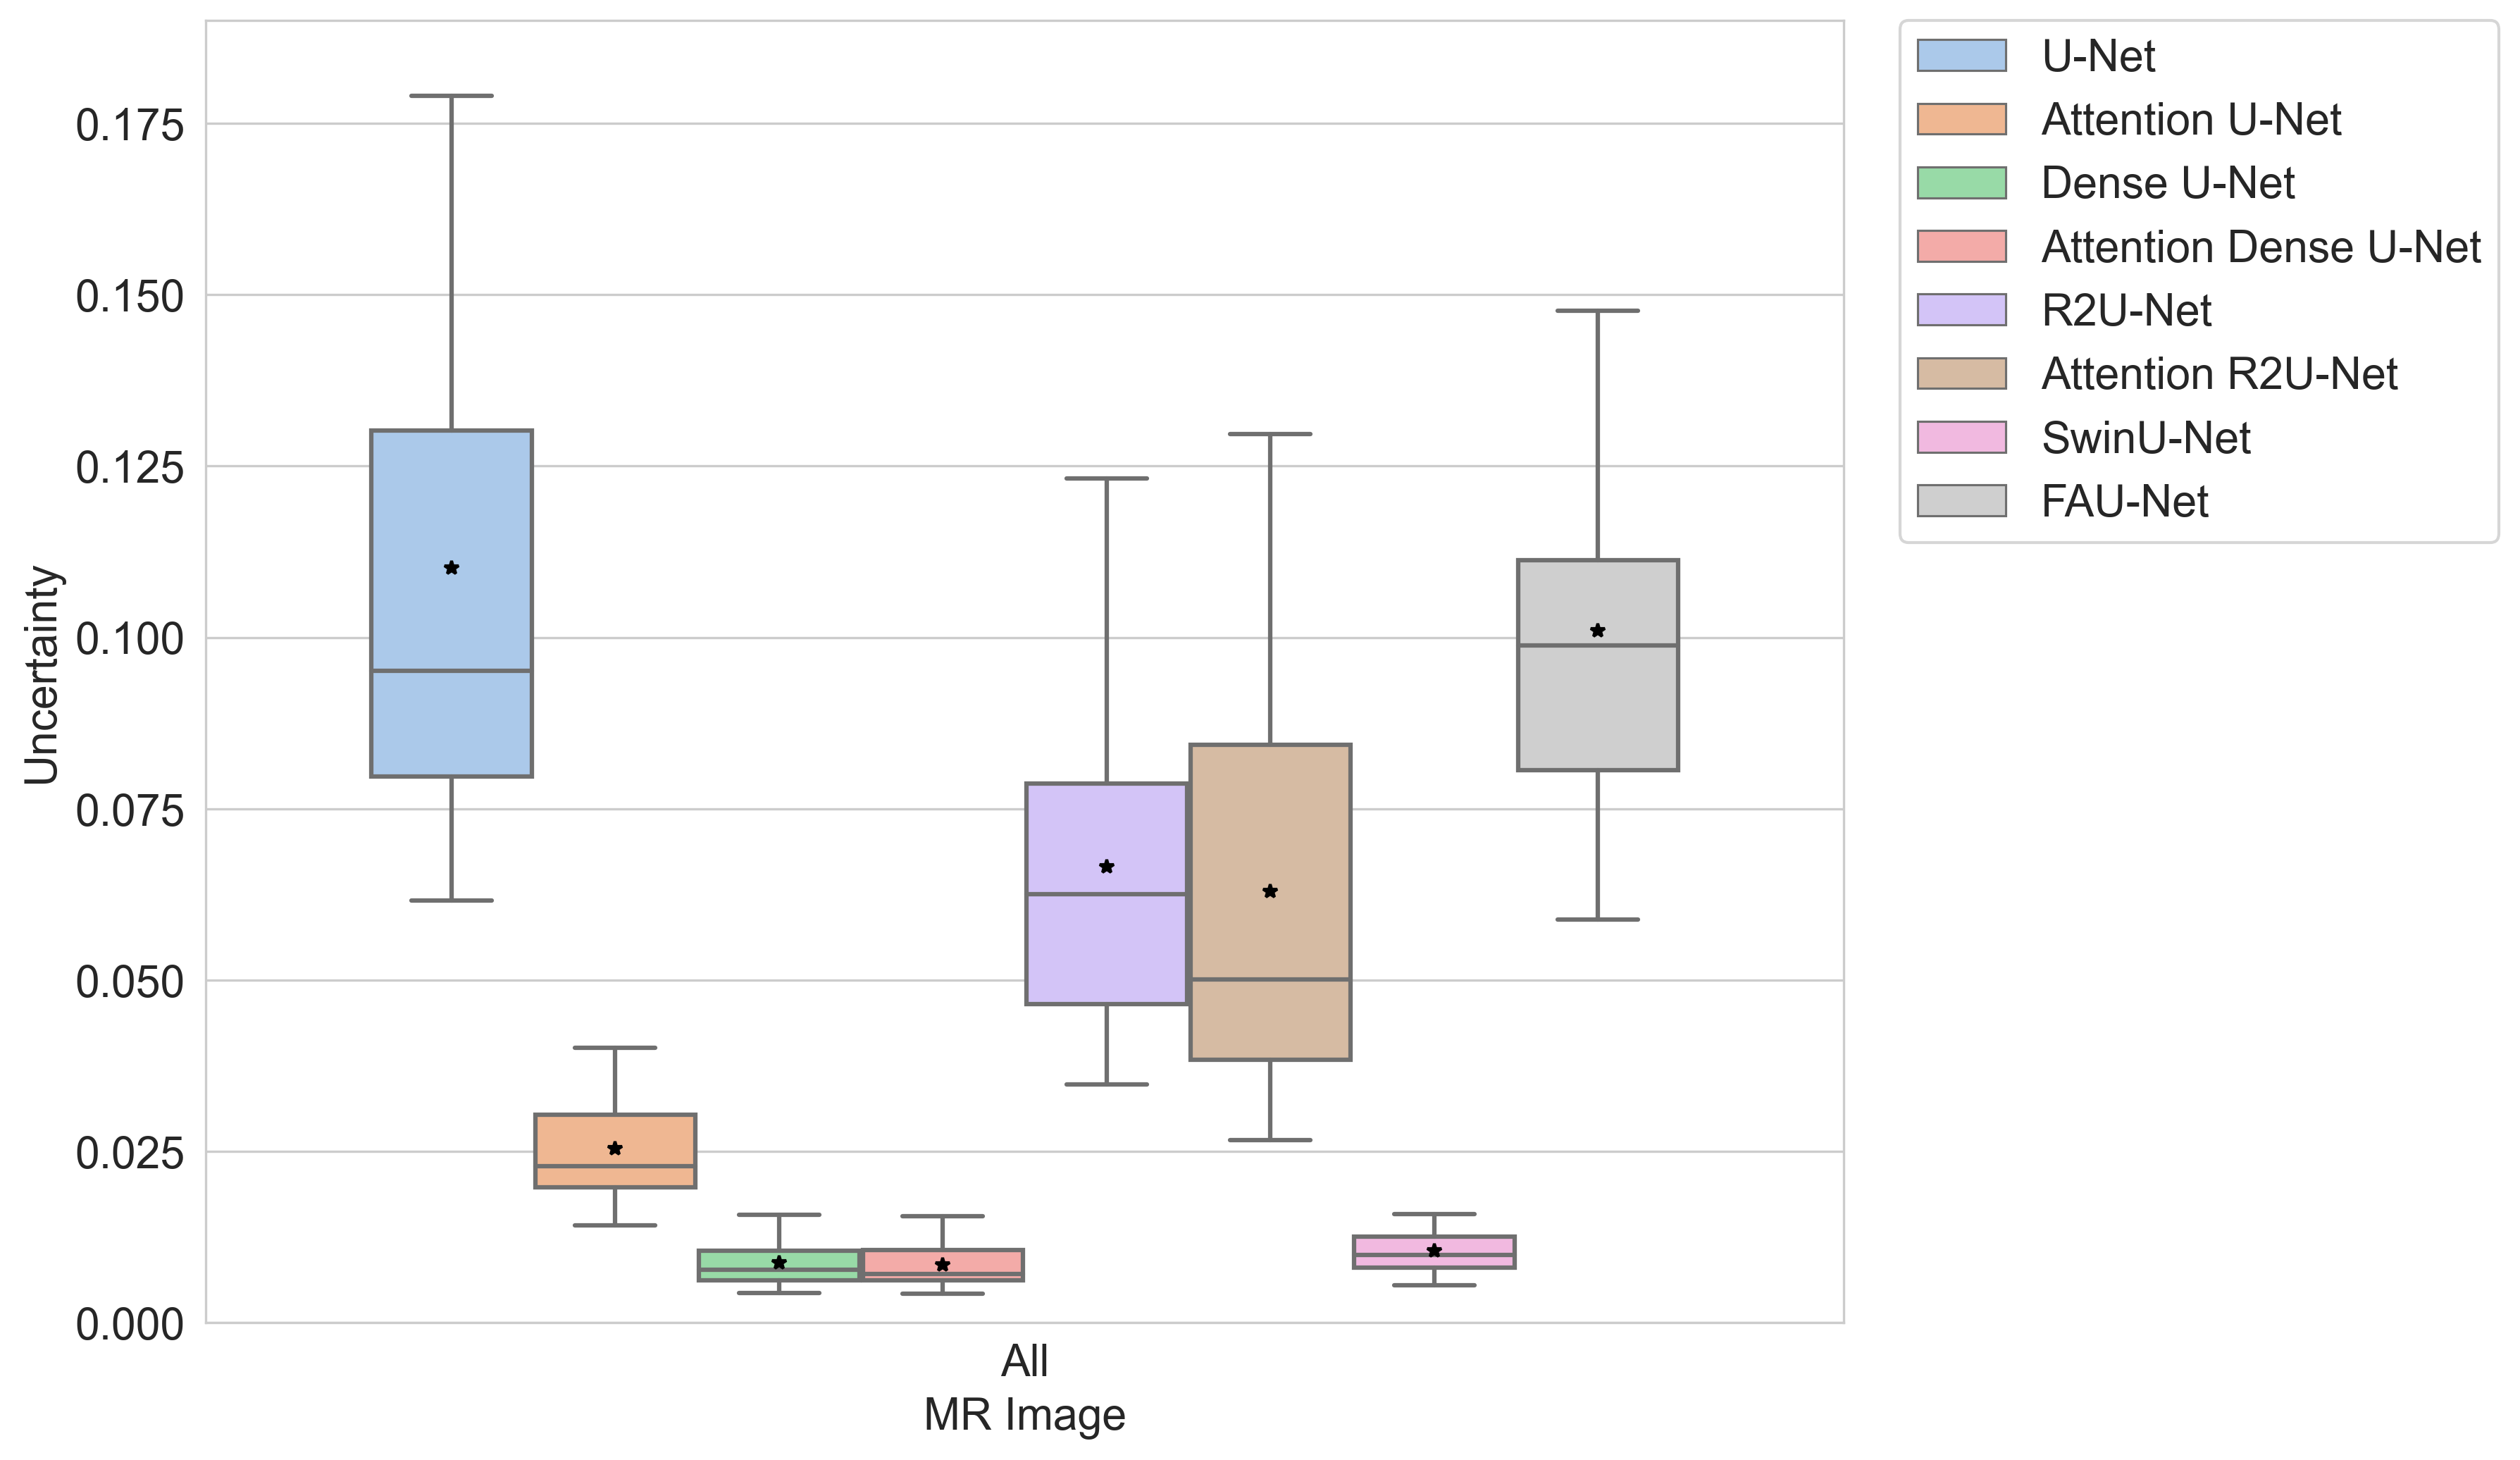

In [72]:
plt.rcParams['font.size'] = 15
plt.figure(figsize=[10,8],dpi=300)
sns.set_style("whitegrid")

# ax_1 = sns.stripplot(x='Zone', y='Uncertainty', hue='Model', data=mdf, size=3, jitter=0.15, dodge= True, 
#               linewidth=0.5,edgecolor='gray', palette='pastel')
ax_2 = sns.boxplot(x="Zone", y="Uncertainty", hue="Model", data=mdf_only_all, fliersize= 0,
                 palette='pastel', showmeans=True, meanprops={"marker": "*",
                       "markeredgecolor": "black",
                       "markersize": "5",
                       "markerfacecolor": 'black'})
ax_2.set_xlabel('MR Image')

handles, labels = ax_2.get_legend_handles_labels()
l = ax_2.legend(handles[0:8], labels[0:8], bbox_to_anchor=(1.4, 1), loc='upper right', borderaxespad=0.)
ax_2.set_ylim(0,0.19)

plt.savefig('Uncertainty_comparison_12-04/uq_boxplot_only_all.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [95]:
meandf = pd.DataFrame({'UNet':df_unet.mean(numeric_only=True),
            'Attention UNet': df_attunet.mean(numeric_only=True),
            'Dense UNet': df_denseunet.mean(numeric_only=True),
            'Attention Dense UNet': df_attdenseunet.mean(numeric_only=True),
            })
meandf.style.highlight_min(color = 'lightgreen', 
                       axis = 1)


,UNet,Attention UNet,Dense UNet,Attention Dense UNet
all,0.373482,0.330590,0.278309,0.273882
gland,0.270961,0.223476,0.176618,0.177744
cz,0.105645,0.089108,0.087638,0.088168
pz,0.112221,0.098777,0.094147,0.093992
tz,0.061992,0.055389,0.048178,0.055933
tum,0.086739,0.041857,0.037021,0.040236


In [126]:
std_unet = df_unet[['all', 'gland', 'cz', 'pz', 'tz', 'tum']].std(ddof=0)
std_attunet = df_attunet[['all', 'gland', 'cz', 'pz', 'tz', 'tum']].std(ddof=0)
std_denseunet = df_denseunet[['all', 'gland', 'cz', 'pz', 'tz', 'tum']].std(ddof=0)
std_attdenseunet = df_attdenseunet[['all', 'gland', 'cz', 'pz', 'tz', 'tum']].std(ddof=0)

meandf = pd.DataFrame({'UNet':df_unet.mean(numeric_only=True),
            'Std UNet': std_unet,
            'Attention UNet': df_attunet.mean(numeric_only=True),
            'Std Attention UNet': std_attunet,
            'Dense UNet': df_denseunet.mean(numeric_only=True),
            'Std Dense UNet': std_denseunet,
            'Attention Dense UNet': df_attdenseunet.mean(numeric_only=True),
            'Std Attention Dense UNet': std_attdenseunet})
print(meandf.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &      UNet &  Std UNet &  Attention UNet &  Std Attention UNet &  Dense UNet &  Std Dense UNet &  Attention Dense UNet &  Std Attention Dense UNet \\
\midrule
all   &  0.373482 &  0.097195 &        0.330590 &            0.071682 &    0.278309 &        0.054483 &              0.273882 &                  0.048703 \\
gland &  0.270961 &  0.083069 &        0.223476 &            0.052282 &    0.176618 &        0.031856 &              0.177744 &                  0.031748 \\
cz    &  0.105645 &  0.024629 &        0.089108 &            0.010736 &    0.087638 &        0.009523 &              0.088168 &                  0.010826 \\
pz    &  0.112221 &  0.024024 &        0.098777 &            0.016429 &    0.094147 &        0.013871 &              0.093992 &                  0.014333 \\
tz    &  0.061992 &  0.014877 &        0.055389 &            0.019051 &    0.048178 &        0.031147 &              0.055933 &                  0.033907 \\
tum   &  0.08673

C:\Users\pablo\AppData\Local\Temp\ipykernel_45808\3875795746.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(meandf.to_latex())
